In [127]:
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray as rioxr
import matplotlib.pyplot as plt
import seaborn as sns
from operator import itemgetter
import numpy as np

### Pull in SNTL Data, basins and closest sntl sites

In [191]:
# UCRB Basins
ucrb_hcdn_basins = gpd.read_file('./ucrb_hcdn_polygons.json')

# Get SNTL data
AWDB_API_DOMAIN = "https://api.snowdata.info"
sntl_meta_url = f"{AWDB_API_DOMAIN}/stations/getMeta?network=SNTL&format=geojson"

# Get the data and rename everything to match the snow ex columns
gdf_sntl = gpd.read_file(sntl_meta_url).rename(
    columns={"name": "site_name", "stationTriplet": "site_id"}
)

gdf_sntl = gdf_sntl.to_crs('4326')
nearest_sntl = {}

for i,basin in enumerate(ucrb_hcdn_basins.centroid):
    # calculate distances between br_geom and the points
    # {index: distance, index: distance, ...} / r[0]: index, r[1]: row in DataFrame
    dist_sntl = {r[1]['site_id']: r[1]['geometry'].distance(basin) for r in gdf_sntl[gdf_sntl['site_id'].str.contains('CO')][['site_id','geometry']].iterrows()}
    # get the nearest point index
    idx_sntl = sorted(dist_sntl.items(), key=itemgetter(1))[:2]
    #get the point by index
    nearest_sntl[ucrb_hcdn_basins.iloc[i]['GAGE_ID']] = [site[0] for site in idx_sntl]

# Pull in sntl data
hcdn_sntl_swe_ds = xr.open_dataset('./co_hcdn_sntl_all_20220930.nc')


C:\Users\dlhogan\AppData\Local\Temp\ipykernel_31000\2743736830.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for i,basin in enumerate(ucrb_hcdn_basins.centroid):


# Open PRISM data

In [192]:
# Download PRISM normals 
outpath = '../../data/PRISM/PRISM_ppt_30yr_normal_800mM4_all_bil/'
files = [x for x in os.listdir(outpath) if (x[-3:] == 'bil') and ('annual' not in x)]
prism_list = []
for file in files:
       prism_list.append(rioxr.open_rasterio(os.path.join(outpath,file)))
prism_normals_ds = xr.concat(prism_list, dim='band')
prism_normals_ds = prism_normals_ds.rename({'band':'month'})

prism_normals_ds = prism_normals_ds.assign_coords({
        'month': [1,2,3,4,5,6,7,8,9,10,11,12]})


### Create SNOTEL Normals Dataset for One Basin

(38.8, 39.1)

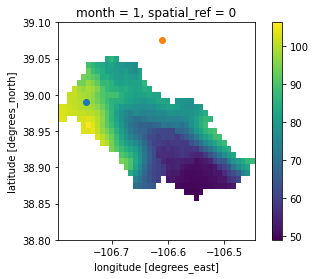

In [193]:
site = 13
tmp_gdf = gpd.GeoDataFrame(ucrb_hcdn_basins.loc[site]).T
basin_prism = prism_normals_ds.rio.clip(tmp_gdf.geometry)
basin_prism = basin_prism.where(basin_prism>=0)

# Create a quick example plot of where the nearest SNTL is on the PRISM data
fig, ax = plt.subplots()
basin_prism.sel(month=1).plot(ax=ax)
gdf_sntl[gdf_sntl['site_id'] == nearest_sntl[ucrb_hcdn_basins.loc[site]['GAGE_ID']][0]].plot(ax=ax);
gdf_sntl[gdf_sntl['site_id'] == nearest_sntl[ucrb_hcdn_basins.loc[site]['GAGE_ID']][1]].plot(ax=ax);
ax.set_ylim(38.8, 39.1)

In [ ]:
# Get sntl PRISM value
x = gdf_sntl[gdf_sntl['site_id'] == nearest_sntl[ucrb_hcdn_basins.loc[site]['GAGE_ID']][0]].geometry.x.values
y = gdf_sntl[gdf_sntl['site_id'] == nearest_sntl[ucrb_hcdn_basins.loc[site]['GAGE_ID']][0]].geometry.y.values
sntl_prism_val = basin_prism.sel(x=x, method='nearest').sel(y=y, method='nearest').squeeze()
prism_multiplier = basin_prism/sntl_prism_val

In [257]:
def single_hcdn_basin_prism_precip(site_no):
    if type(site_no) is str:
        tmp_gdf = ucrb_hcdn_basins[ucrb_hcdn_basins['GAGE_ID']==site_no]
        sntl_id = nearest_sntl[site_no][0]
        x = gdf_sntl[gdf_sntl['site_id'] == nearest_sntl[site_no][0]].geometry.x.values
        y = gdf_sntl[gdf_sntl['site_id'] == nearest_sntl[site_no][0]].geometry.y.values
        
    else:
        tmp_gdf = gpd.GeoDataFrame(ucrb_hcdn_basins.loc[site_no]).T
        sntl_id = nearest_sntl[ucrb_hcdn_basins.loc[site_no]['GAGE_ID']][0]
        x = gdf_sntl[gdf_sntl['site_id'] == nearest_sntl[sntl_id]].geometry.x.values
        y = gdf_sntl[gdf_sntl['site_id'] == nearest_sntl[sntl_id]].geometry.y.values
        
    tmp_gdf = tmp_gdf.set_crs('4326')
    
    basin_prism = prism_normals_ds.rio.clip(tmp_gdf.geometry)
    basin_prism = basin_prism.where(basin_prism>=0)

    # Get sntl PRISM value

    if not tmp_gdf.set_crs(4326).reset_index().contains(gdf_sntl[gdf_sntl['site_id'] == sntl_id].reset_index()).values:
        print('Nearest SNTL is not in basin!')
    
    sntl_prism_val = prism_normals_ds.sel(x=x, method='nearest').sel(y=y, method='nearest').squeeze()
    # Create prism multiplier
    prism_multiplier = basin_prism/sntl_prism_val

    # Get monthly precip from SNOTEL
    single_site = hcdn_sntl_swe_ds.sel(Location=sntl_id).dropna(dim='Date')
    time_first = single_site.resample(Date='1M').first()['PREC']
    time_last = single_site.resample(Date='1M').last()['PREC']
    sntl_monthly_precip = (time_last - time_first) * 10 # convert to mm

    # Create list for monthly prism datasets
    monthly_prism = []
    for mo in np.arange(1,13,1):
        tmp_ds = prism_multiplier.sel(month=mo) * sntl_monthly_precip.where(sntl_monthly_precip.Date.dt.month==mo)
        tmp_ds.name = 'prism_precip'
        tmp_ds = tmp_ds.to_dataframe().dropna().to_xarray()
        monthly_prism.append(tmp_ds)
    ds = xr.concat(monthly_prism,dim='Date').sortby('Date')
    ds = ds.assign_coords({'WY':ds.Date.dt.year.where(ds.Date.dt.month < 10, ds.Date.dt.year + 1)})
    return ds[['prism_precip']]

In [255]:
def get_monthly_prism_anomalies(ds):
    # Get monthly normalized values of sublimation/evaporation and precipitation
    ds_mean = ds.groupby('Date.month').mean("Date")
    ds_std = ds.groupby('Date.month').std("Date")

    stand_anomalies = xr.apply_ufunc(
        lambda x,m,s: (x-m)/s,
        ds.groupby("Date.month"),
        ds_mean,
        ds_std,
        dask='parallelized'
    )
    return stand_anomalies

In [258]:
ds = single_hcdn_basin_prism_precip(list(nearest_sntl.keys())[15])

Nearest SNTL is not in basin!


In [260]:
get_monthly_prism_anomalies(ds).mean(dim='x').mean(dim='y')

c:\Users\dlhogan\anaconda3\envs\sos_env\lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\dlhogan\anaconda3\envs\sos_env\lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\dlhogan\anaconda3\envs\sos_env\lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\dlhogan\anaconda3\envs\sos_env\lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\dlhogan\anaconda3\envs\sos_env\lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=o

<xarray.DataArray 'prism_precip' (Date: 500)>
array([-3.05029286e-01, -1.42461160e-02, -1.51351225e-01, -1.09558216e+00,
       -1.13224935e+00, -1.67418544e+00, -4.08103800e-01, -1.89780043e-01,
       -1.62783505e+00,  1.47663545e+00, -1.19765535e+00,  1.62707229e+00,
       -4.68982527e-01, -6.26829105e-01, -3.66834325e-01, -6.25247061e-01,
        1.41729114e+00, -7.07423913e-01,  9.24620022e-01,  2.92045378e-01,
        6.41318750e-02, -5.46857877e-01, -4.11727036e-01, -5.78522376e-01,
       -1.43562206e-01,  2.25567137e+00,  1.25049323e+00,  1.69389162e+00,
        3.69489415e-01,  5.78879817e-01,  1.82636285e+00, -1.44360642e+00,
       -2.59092775e-01,  2.35354192e+00,  2.85833577e+00, -9.00776219e-01,
       -6.06509995e-01, -1.15675455e-01,  8.00754438e-01,  1.00679690e-01,
        1.20529995e+00,  1.25271784e+00,  2.40019919e+00,  2.92045378e-01,
        2.21896287e+00,  1.58644777e-01,  2.53370484e-01, -3.85170070e-01,
       -7.38780791e-01, -1.15675455e-01, -8.77539110e-03, -4.78670104e-01,
       -4.66321124e-01,  3.54267143e-01, -1.53467859e+00,  2.74237733e+00,
        7.10581175e-01,  1.25609335e+00, -7.91782762e-02, -7.07423913e-01,
        3.29547851e+00, -8.56721336e-01,  6.20858920e-01, -1.20285735e+00,
        9.96347320e-01,  1.32758873e+00, -3.87005906e-01, -5.24731940e-01,
        4.95098075e-01,  1.58644777e-01, -1.13224935e+00,  1.30436079e-01,
       -1.13559318e+00, -3.37989219e-01, -1.80773057e+00, -5.51088828e-01,
        5.60604630e-02,  5.47835789e-02,  2.28771964e-02, -9.33120599e-01,
...
       -1.00332238e+00,  3.28952074e-01, -8.18305220e-01, -5.51088828e-01,
       -1.19765535e+00, -6.93925332e-01,  2.28771964e-02, -1.03521776e+00,
       -1.22876672e+00, -1.25236053e+00,  2.41493742e+00,  2.77291760e+00,
        1.20979387e-01, -1.30134887e+00, -9.08252979e-01,  9.69704381e-01,
       -1.40660798e+00,  5.04008926e-01, -3.05029286e-01, -4.22634775e-01,
        3.87356525e-01, -1.54911958e-01,  3.16713105e-02, -3.85170070e-01,
        5.48439889e-02, -6.34407572e-01,  1.71120126e-01, -6.23507553e-01,
       -1.09317903e+00, -1.21802157e+00, -1.20677211e+00, -6.26829105e-01,
        1.71873425e-01,  1.80481764e+00, -7.99700590e-01,  2.59337617e-01,
       -5.40374596e-01,  2.03335760e+00, -2.78618667e-01, -4.41577587e-02,
        9.96347320e-01, -1.74211781e+00, -1.12479549e+00, -1.23941209e+00,
        1.35703047e+00, -1.01719298e+00,  1.42520897e-01, -6.29162266e-02,
        1.37755196e+00, -4.86198396e-01,  6.20858920e-01, -1.13043862e+00,
        3.69489415e-01, -6.19054441e-01, -1.69863183e+00, -8.31023434e-01,
       -1.55199137e+00, -7.65227746e-02, -7.44275796e-01, -7.07423913e-01,
        5.48439889e-02, -2.63884631e-01, -1.53788729e+00, -4.06251380e-01,
       -5.70797442e-01,  1.77681407e+00, -2.23052665e-01, -9.33120599e-01,
        3.87356525e-01, -2.33301142e-01,  3.64220071e-01,  1.53454211e-03,
       -1.00332238e+00, -6.34407572e-01, -9.87231499e-02, -1.88995207e-01,
       -5.70797442e-01, -3.19570877e-01,  1.90833947e+00, -3.20537610e-01])
Coordinates:
  * Date     (Date) datetime64[ns] 1980-08-31 1980-09-30 ... 2022-09-30
    WY       (Date) int64 1980 1980 1981 1981 1981 ... 2022 2022 2022 2022 2022
    month    (Date) int64 8 9 10 11 12 1 2 3 4 5 6 7 ... 11 12 1 2 3 4 5 6 7 8 9